# Sargassum Detection Notebook

This notebook presents a prototype for detecting Sargassum algae using a Geospatial Data Cube with [Open Data Cube (ODC)](https://www.opendatacube.org). The implementation is based on the work by the [National Earth Observation Laboratory](http://www.lanot.unam.mx). Sargassum is a type of seaweed that can accumulate in large quantities along coastlines, affecting marine life and tourism. Detecting and monitoring Sargassum is crucial for environmental management and mitigation efforts.

*Code Translated by Irving G. Cabrera Zamora, based on the original code from [Uriel Mendoza's repository](https://github.com/UrielMendoza/LANOT_INEGI_opdc_sargazo).*

---

## 1. Importing Libraries

First, we install and import the necessary libraries for data processing and visualization.

### **Installing Extra Libraries**

We install `deafrica-tools`, which provides additional tools for working with the Digital Earth Africa platform. Although we are not using Digital Earth Africa directly, these tools offer useful functions for spatial data handling.

In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install hdstats deafrica-tools

**Importing Required Libraries**

In [1]:
import datacube
import sys
import numpy as np
import geopandas as gpd
import xarray as xr
from tqdm.notebook import tqdm
from skimage.filters.rank import entropy
from skimage.morphology import disk
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
from odc.ui import DcViewer
from odc.ui import with_ui_cbk
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.spatial import xr_vectorize, xr_rasterize

**Explanation of Libraries:**

- **datacube**: Core library for accessing and managing the geospatial data cube.
- **sys**: Provides access to system-specific parameters and functions.
- **numpy**: Fundamental package for numerical computations.
- **geopandas**: Extends pandas to allow spatial operations on geometric types.
- **xarray**: Used for working with labeled multi-dimensional arrays.
- **tqdm.notebook**: Provides progress bars in Jupyter notebooks.
- **skimage.filters.rank.entropy**: Function to calculate the entropy of an image.
- **skimage.morphology.disk**: Generates a disk-shaped structuring element.
- **matplotlib.pyplot**: Plotting library for visualization.
- **datacube.utils.cog.write_cog**: Utility to write Cloud Optimized GeoTIFFs.
- **shapely.geometry**: Used for manipulation and analysis of planar geometric objects.
- **odc.ui**: Provides utilities for user interfaces in ODC.
- **deafrica_tools**: Provides spatial analysis tools for raster and vector data and for plotting spatial data.

---

## 2. Accessing the Data Cube

We create a connection to the data cube, which will allow us to query and retrieve satellite data for our analysis.

In [2]:
dc = datacube.Datacube(app="Sargassum_Detection")

- **datacube.Datacube(app="Sargassum_Detection")**: Initializes a connection to the data cube with the application name "Sargassum_Detection".

---

## 3. Exploring the Data Cube

### **Listing Available Products**

We list all the products available in the data cube to identify which datasets we can use.

In [3]:
product = "s2_ard_scene"

measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
B01_60m,B01_60m,int16,reflectance,-9999,"[band_1, coastal_aerosol]",NaN
B02_10m,B02_10m,int16,reflectance,-9999,"[band_2, blue]",NaN
B03_10m,B03_10m,int16,reflectance,-9999,"[band_3, green]",NaN
B04_10m,B04_10m,int16,reflectance,-9999,"[band_4, red]",NaN
B05_20m,B05_20m,int16,reflectance,-9999,"[band_5, veg5]",NaN
B06_20m,B06_20m,int16,reflectance,-9999,"[band_6, veg6]",NaN
B07_20m,B07_20m,int16,reflectance,-9999,"[band_7, veg7]",NaN
B08_10m,B08_10m,int16,reflectance,-9999,"[band_8, nir]",NaN
B8A_20m,B8A_20m,int16,reflectance,-9999,"[band_8a, narrow_nir]",NaN


- **product = "s2_ard_scene"**: Specifies the product to use.
- **dc.list_measurements()**: Lists all available measurements (bands) for each product.
- **measurements.loc[product]**: Retrieves the measurements for the selected product.

---

## 4. Defining the Analysis Area and Time Range

We define the spatial and temporal extent of our analysis.

In [4]:
# Define the time range for analysis
time_range = ("2023-05-21", "2023-05-22")
# Alternative time range example
# time_range = ("2016-05-01", "2016-05-10")

# Define the latitude and longitude ranges for the area of interest
lat_range = (20.7, 21.6)
lon_range = (-87, -86)
# Alternative spatial extent example
# lat_range = (20.82, 21.5)
# lon_range = (-86.4, -86.9)

- **time_range**: Specifies the date range for which we want to retrieve data.
- **lat_range** and **lon_range**: Define the geographic boundaries of the area of interest (e.g., coastal region prone to Sargassum accumulation).

### **Visualizing the Area of Interest**

We display the area on a map to confirm the spatial extent.

In [5]:
display_map(x=lon_range, y=lat_range)

**display_map()**: Function that generates an interactive map centered on the specified coordinates.

## 5. Checking Data Availability

Before loading data, we check if there are any datasets available for the specified time and area.

In [6]:
datasets = dc.find_datasets(product=["s2_ard_scene"], time=time_range)
datasets

[Dataset <id=c6c231d0-faff-4105-8a62-d4d3625b348e product=s2_ard_scene location=file:///datacube/original_data/S2A_MSIL2A_20230521T160831_N9999_R140_T16PCC_20230522T100508/agdc-metadata.yaml>,
 Dataset <id=d811c801-1cb0-44d3-b45c-ac7ebc559b09 product=s2_ard_scene location=file:///datacube/original_data/S2A_MSIL2A_20230521T160831_N9999_R140_T16PDC_20230522T103513/agdc-metadata.yaml>,
 Dataset <id=a1fa6f32-e74e-4a92-b84b-6a905066a8b0 product=s2_ard_scene location=file:///datacube/original_data/S2A_MSIL2A_20230521T160831_N9999_R140_T16PEC_20230522T110838/agdc-metadata.yaml>,
 Dataset <id=d03229c1-8e66-478a-89d6-1314119e6883 product=s2_ard_scene location=file:///datacube/original_data/S2A_MSIL2A_20230521T160831_N9999_R140_T16QCD_20230522T080623/agdc-metadata.yaml>,
 Dataset <id=d9c9d799-84ec-4646-a819-c8710593c662 product=s2_ard_scene location=file:///datacube/original_data/S2A_MSIL2A_20230521T160831_N9999_R140_T16QCE_20230522T061737/agdc-metadata.yaml>,
 Dataset <id=313d9435-8afb-4d15-a5f

**dc.find_datasets()**: Searches for datasets matching the specified product and time range.
## 6. Loading the Dataset

We load the dataset for the specified time range, spatial extent, and the bands needed for Sargassum detection.

In [7]:
ds_ = dc.load(
    product=["s2_ard_scene"],
    measurements=['blue', 'green', 'red', 'slc', 'swir1', 'nir', 'narrow_nir', 'swir2'],
    x=lon_range,
    y=lat_range,
    time=time_range,
    output_crs='EPSG:32616',  # UTM Zone 16N
    resolution=(-20, 20),      # 20-meter resolution
    progress_cbk=with_ui_cbk(),  # Display progress
)

**Parameters:**

- **product**: Specifies the product(s) to load.
- **measurements**: List of spectral bands and additional layers to include:
  - **'blue', 'green', 'red'**: Visible spectrum bands.
  - **'nir', 'narrow_nir'**: Near-Infrared bands.
  - **'swir1', 'swir2'**: Short-Wave Infrared bands.
  - **'slc'**: Scene Classification Layer (useful for cloud masking).
- **x, y**: Longitude and latitude ranges.
- **time**: Time range.
- **output_crs**: Coordinate Reference System for the output data.
- **resolution**: Spatial resolution in meters.
- **progress_cbk**: Callback function to display progress.

### **Selecting the First Time Slice**

We select the dataset corresponding to the first available date.

In [8]:
ds = ds_.isel(time=0)
ds

<xarray.Dataset>
Dimensions:      (x: 5207, y: 4998)
Coordinates:
    time         datetime64[ns] 2023-05-21T16:24:57.500000
  * y            (y) float64 2.389e+06 2.389e+06 ... 2.289e+06 2.289e+06
  * x            (x) float64 5e+05 5e+05 5.000e+05 ... 6.041e+05 6.041e+05
    spatial_ref  int32 32616
Data variables:
    blue         (y, x) int16 2316 2288 2378 2292 2292 ... 2011 1961 1936 1996
    green        (y, x) int16 2310 2336 2386 2312 2320 ... 1954 1850 1833 1826
    red          (y, x) int16 1268 1286 1285 1286 1290 ... 1988 1750 1832 1860
    slc          (y, x) uint8 6 6 6 6 6 6 6 6 6 6 6 6 ... 2 2 2 2 2 2 2 2 2 2 2
    swir1        (y, x) int16 1171 1170 1179 1176 1180 ... 1843 1854 1836 1843
    nir          (y, x) int16 1188 1200 1218 1216 1195 ... 1842 1771 1718 1846
    narrow_nir   (y, x) int16 1182 1193 1202 1198 1210 ... 1842 1887 1898 1883
    swir2        (y, x) int16 1153 1151 1158 1168 1172 ... 1776 1762 1781 1759
Attributes:
    crs:           EPSG:32616
    grid_mapping:  spatial_ref

- **ds_.isel(time=0)**: Selects the first time index from the loaded dataset.

---

## 7. Visualizing the Dataset

We create a true-color image using the red, green, and blue bands to visualize the area.

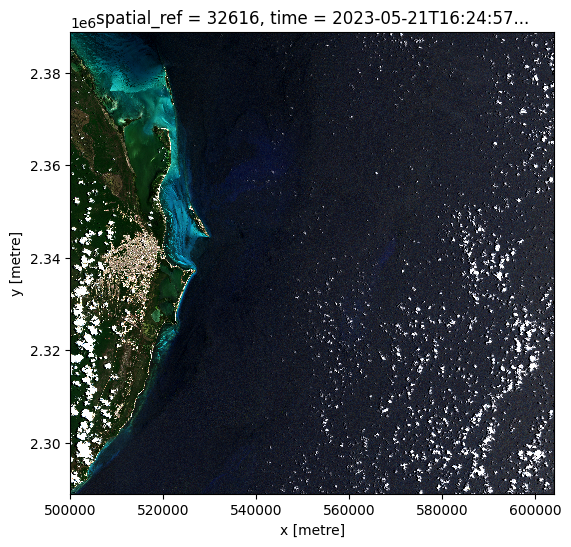

In [9]:
rgb(ds, bands=["red", "green", "blue"])

- **rgb()**: Function that plots an RGB composite image using specified bands.

---

## 8. Calculating Cloud Percentage

Cloud cover can significantly impact the accuracy of our analysis. We calculate the percentage of clouds in the scene.

### **Defining Function to Calculate Cloud Percentage**

In [10]:
def calculate_cloud_percentage(ds):
    """
    Calculates the percentage of clouds in the dataset using the Scene Classification Layer (SCL).

    Parameters:
    ds (xarray.Dataset): The dataset containing the 'slc' variable.

    Returns:
    float: The percentage of cloud pixels in the dataset.
    """
    # Identify cloud pixels based on SCL values
    cloud_mask = (ds.slc == 8) | (ds.slc == 9) | (ds.slc == 10) | (ds.slc == 11)
    # Calculate the percentage of cloud pixels
    cloud_percentage = 100 * (cloud_mask.sum()) / (ds.dims["x"] * ds.dims["y"])
    return cloud_percentage

# Calculate the cloud percentage
cloud_percentage = calculate_cloud_percentage(ds)

print(f'Cloud Percentage: {cloud_percentage.item():.2f}%')

Cloud Percentage: 3.39%


- **SCL Values for Clouds**:
  - **8**: Cloud medium probability.
  - **9**: Cloud high probability.
  - **10**: Thin cirrus.
  - **11**: Cloud shadows.

### **Handling Scenes with Excessive Cloudiness**

We define conditions based on the cloud percentage to determine whether to proceed with processing.

In [11]:
# Check cloud conditions
if cloud_percentage >= 80.0:
    print('=============================================')
    print('Image with excessive cloudiness; processing will be skipped.')
    print('=============================================')
    exit()

# Set parameters based on cloud percentage
elif cloud_percentage >= 30.0:
    low_clouds = 0.02
    cloud_buffer = 200
    apply_buffer = True
else:
    low_clouds = 0.04
    cloud_buffer = 400
    apply_buffer = True

print(f"Low Clouds Threshold: {low_clouds}")
print(f"Cloud Buffer Size: {cloud_buffer} meters")
print(f"Apply Buffer: {apply_buffer}")

Low Clouds Threshold: 0.04
Cloud Buffer Size: 400 meters
Apply Buffer: True


- **Conditions**:
  - If cloud percentage is **80% or higher**, skip processing.
  - If cloud percentage is between **30% and 80%**, set parameters for low clouds and buffer size.
  - If cloud percentage is below **30%**, adjust parameters accordingly.
- **Variables**:
  - **low_clouds**: Threshold for low cloud reflectance (used later in processing).
  - **cloud_buffer**: Distance in meters to buffer around cloud areas.
  - **apply_buffer**: Flag to indicate whether to apply a buffer around clouds.

---

## 9. Generating the Cloud Mask

We create a mask to exclude cloud-covered areas from our analysis.

### **Defining Function to Create Cloud Mask**

In [12]:
def create_cloud_mask(ds):
    """
    Generates a cloud mask by identifying cloud pixels and applying a buffer.

    Parameters:
    ds (xarray.Dataset): The dataset containing the 'slc' variable.

    Returns:
    xarray.DataArray: A DataArray representing the cloud mask.
    """
    # Identify cloud pixels based on SCL values
    cloud_mask = (ds.slc == 8) | (ds.slc == 9) | (ds.slc == 10) | (ds.slc == 11)

    # Vectorize the cloud mask to create polygons
    cloud_mask_vect = xr_vectorize(
        cloud_mask,
        crs=ds.crs,
        mask=cloud_mask.values == 1
    )

    # Validate and correct geometries
    is_valid = cloud_mask_vect.geometry.is_valid
    invalid_geoms = cloud_mask_vect[~is_valid].index.tolist()
    for idx in invalid_geoms:
        geom_ext = cloud_mask_vect.geometry[idx].exterior
        new_poly = Polygon(geom_ext.coords)
        cloud_mask_vect.geometry[idx] = new_poly

    if len(cloud_mask_vect) == 0:
        print("No cloud buffer needed.")
        return None
    else:
        print("Applying cloud buffer.")
        # Apply buffer around cloud polygons
        cloud_mask_vect = cloud_mask_vect.buffer(cloud_buffer)
        # Rasterize the buffered cloud mask back to the dataset grid
        cloud_mask_raster = xr_rasterize(
            gdf=cloud_mask_vect,
            da=ds,
            crs=ds.crs
        )
        return cloud_mask_raster

**Explanation:**

- **xr_vectorize()**: Converts a raster mask into vector geometries (polygons).
- **Geometry Validation**: Ensures that the geometries are valid; repairs any invalid geometries.
- **Buffering**: Expands the cloud polygons by the specified buffer distance to account for potential cloud edges.
- **xr_rasterize()**: Converts vector geometries back into a raster mask aligned with the original dataset grid.

### **Generating and Visualizing the Cloud Mask**

In [13]:
cloud_mask = create_cloud_mask(ds)
cloud_mask

Applying cloud buffer.


<xarray.DataArray (y: 4998, x: 5207)>
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 2.389e+06 2.389e+06 2.389e+06 ... 2.289e+06 2.289e+06
  * x        (x) float64 5e+05 5e+05 5.000e+05 ... 6.041e+05 6.041e+05 6.041e+05
Attributes:
    crs:           EPSG:32616
    grid_mapping:  spatial_ref

- **cloud_mask**: The rasterized cloud mask after buffering.

### **Plotting the Cloud Mask**

## 10. Calculating Sargassum Presence

We apply an algorithm to detect Sargassum using spectral band thresholds.

### **Defining Functions for Sargassum Detection**

#### **Standardizing Band Values**

In [14]:
def standardize_band(band):
    """
    Converts the band values to Top-of-Atmosphere reflectance.

    Parameters:
    band (xarray.DataArray): The spectral band to standardize.

    Returns:
    xarray.DataArray: The standardized band.
    """
    return ((band - 1000) * 0.0001)

#### **Sargassum Detection Algorithm**

In [15]:
def detect_sargassum(ds):
    """
    Applies spectral thresholds to detect Sargassum presence.

    Parameters:
    ds (xarray.Dataset): The dataset containing the necessary bands.

    Returns:
    xarray.DataArray: A binary mask where 1 indicates potential Sargassum presence.
    """
    # Standardize bands
    b11 = standardize_band(ds.swir1)
    b8A = standardize_band(ds.narrow_nir)
    b08 = standardize_band(ds.nir)
    b04 = standardize_band(ds.red)

    # Apply spectral thresholds
    sargassum_mask = xr.where(
        (b8A > 0.07) & 
        (b04 < 0.1) & 
        (b11 < 0.05) & 
        (b04 < b8A) & 
        (b04 < b08),
        1, 0
    )
    return sargassum_mask

**Explanation:**

- The algorithm identifies pixels that meet specific spectral criteria associated with Sargassum presence.
- **Thresholds**:
  - **b8A > 0.07**: Narrow NIR reflectance is high.
  - **b04 < 0.1**: Red reflectance is low.
  - **b11 < 0.05**: SWIR1 reflectance is low.
  - **b04 < b8A** and **b04 < b08**: Red reflectance is less than NIR bands.

### **Applying the Sargassum Detection Algorithm**

In [16]:
sargassum_mask = detect_sargassum(ds)

### **Visualizing the Sargassum Detection Result**

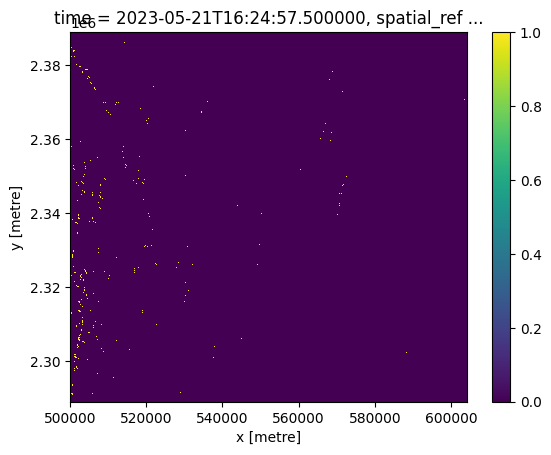

In [17]:
sargassum_mask.plot()

The plot displays areas where Sargassum is potentially present (value of 1).

## 11. Applying Entropy Filter

To reduce false positives, we apply an entropy filter which measures the texture complexity in the SWIR2 band.

### **Defining Entropy Calculation Function**

In [18]:
def calculate_entropy(ds):
    """
    Calculates the entropy of the SWIR2 band using a moving window.

    Parameters:
    ds (xarray.Dataset): The dataset containing the 'swir2' band.

    Returns:
    xarray.DataArray: The entropy values for the SWIR2 band.
    """
    # Calculate entropy using a disk-shaped structuring element
    entropy_values = entropy(ds.swir2, disk(5))
    entropy_da = ds.swir2.copy()
    entropy_da.data = entropy_values
    return entropy_da

- **entropy()**: Calculates the entropy (texture measure) of an image.
- **disk(5)**: Creates a circular structuring element with a radius of 5 pixels.

### **Defining Pixel Filtering Function**

In [19]:
def filter_pixels(ds, sargassum_mask, cloud_mask):
    """
    Filters the Sargassum detection mask using entropy and cloud masks.

    Parameters:
    ds (xarray.Dataset): The original dataset.
    sargassum_mask (xarray.DataArray): The initial Sargassum detection mask.
    cloud_mask (xarray.DataArray): The cloud mask.

    Returns:
    xarray.DataArray: The filtered Sargassum detection mask.
    """
    # Entropy threshold
    entropy_min = 4.0
    # Calculate entropy
    entropy_da = calculate_entropy(ds)
    # Standardize SWIR2 band
    b12 = standardize_band(ds.swir2)
    scl = ds.slc  # Scene Classification Layer

    print('=============================================')
    print(f'Sargassum detections before filtering: {(sargassum_mask == 1).sum().item()} pixels')
    print('=============================================')

    # Apply filters
    nu_mask = (
        (entropy_da < entropy_min) &       # Low entropy
        (sargassum_mask == 1) &            # Detected as Sargassum
        (~cloud_mask) &                    # Not in cloud-covered area
        ((scl != 3) & (scl != 8) & (scl != 9) & (scl != 10) & (scl != 11))  # Exclude certain SCL classes
    )

    print(f'Filtered by entropy: {((entropy_da >= entropy_min) & (sargassum_mask == 1)).sum().item()} pixels')
    print(f'Filtered by clouds: {((sargassum_mask == 1) & (cloud_mask)).sum().item()} pixels')

    return nu_mask

**Explanation:**

- **Filters Applied**:
  - **Entropy Filter**: Excludes pixels with high entropy (complex textures), which are less likely to be Sargassum.
  - **Cloud Mask**: Excludes pixels covered by clouds.
  - **SCL Exclusions**: Excludes pixels classified as snow, clouds, shadows, etc.

### **Applying the Pixel Filtering**

In [20]:
filtered_sargassum_mask = filter_pixels(ds, sargassum_mask, cloud_mask)

/tmp/ipykernel_667/1888350554.py:12: UserWarning: Possible precision loss converting image of type int16 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropy_values = entropy(ds.swir2, disk(5))


Sargassum detections before filtering: 48684 pixels
Filtered by entropy: 97 pixels
Filtered by clouds: 31514 pixels


### **Visualizing the Filtered Result**

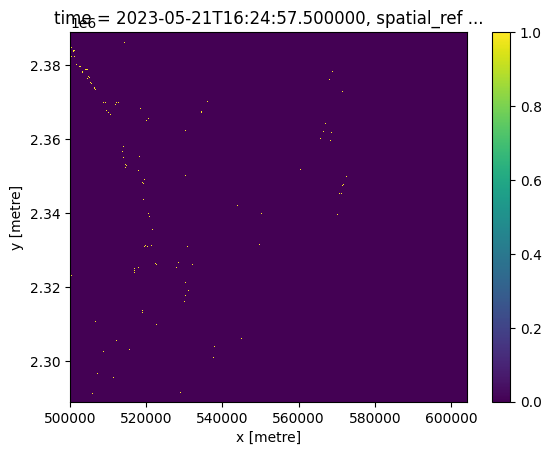

In [21]:
filtered_sargassum_mask.plot()

## 12. Visualizing Detected Sargassum on RGB Image

We overlay the filtered Sargassum detections on the RGB image for visual confirmation.

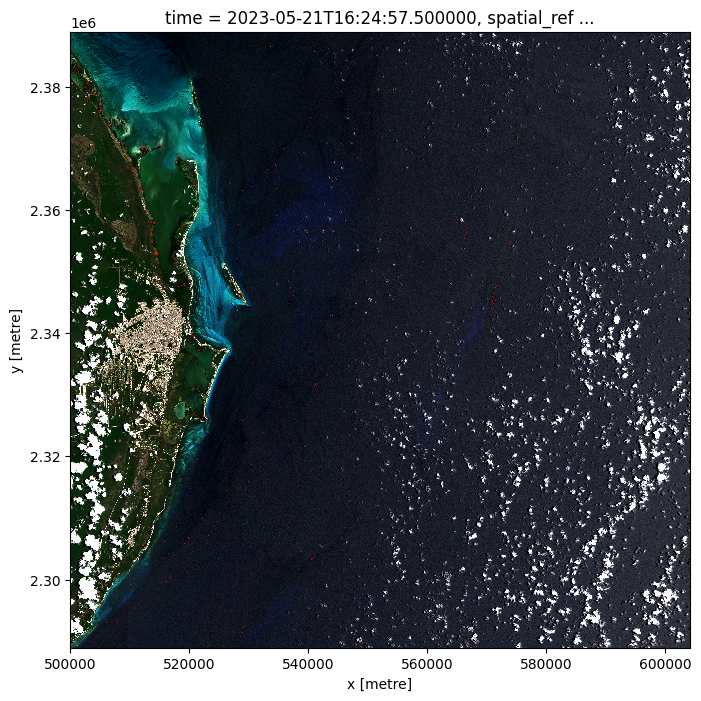

In [22]:
fig, ax1 = plt.subplots(figsize=[8, 8])
rgb(
    ds,
    bands=["red", "green", "blue"],
    ax=ax1,
)
xr.where(filtered_sargassum_mask, 1, np.NaN).plot(ax=ax1, cmap="brg", add_colorbar=False)
plt.show()

- **xr.where()**: Masks the RGB image to highlight the detected Sargassum areas.
- **cmap="brg"**: Uses a colormap to display the detections.

---

## 13. Polygonizing Detected Sargassum

We convert the raster detections into vector polygons and add additional information.

### **Defining Polygonization Function**

In [23]:
def polygonize_sargassum(ds, filtered_mask, land_mask_path):
    """
    Converts the filtered Sargassum detection mask into polygons and adds attributes.

    Parameters:
    ds (xarray.Dataset): The original dataset.
    filtered_mask (xarray.DataArray): The filtered Sargassum detection mask.
    land_mask_path (str): Path to the land mask GeoJSON file.

    Returns:
    geopandas.GeoDataFrame: The polygons with additional attributes.
    """
    # Vectorize the filtered mask
    df = xr_vectorize(
        filtered_mask,
        crs=ds.crs,
        mask=filtered_mask.values == 1
    )
    print('=============================================')
    print(f'Sargassum detections after pixel filtering: {len(df)} polygons')
    print('=============================================')

    # Get the date from the dataset
    date_str = ds.time.dt.strftime("%Y%m%dT%H%M%S").item()
    date_display = ds.time.dt.strftime("%x").item()

    if len(df) >= 1:
        df['ID'] = range(1, len(df) + 1)
        df['date'] = date_str
        df['display_date'] = date_display

        # Calculate distance to the coastline
        coastline = gpd.read_file(land_mask_path + 'land_UTM16N_20m_2021.geojson')
        distances = []
        for i in range(len(df)):
            distance = round(coastline.geometry.iloc[0].distance(df.geometry.iloc[i]) * 0.001, 4)  # Convert to kilometers
            distances.append(distance)
        df['distance_to_coast_km'] = distances

        # Drop unnecessary columns
        df = df.drop(columns=['attribute'])

        return df
    else:
        print('=========================')
        print('NO SARGASSUM DETECTIONS')
        print('=========================')
        return None

**Explanation:**

- **xr_vectorize()**: Converts the raster mask into vector polygons.
- **Adding Attributes**:
  - **ID**: Unique identifier for each polygon.
  - **date**: Timestamp of the dataset.
  - **distance_to_coast_km**: Distance from each polygon to the coastline.
- **Calculating Distance to Coastline**:
  - Reads a GeoJSON file containing the land mask.
  - Calculates the distance between each Sargassum polygon and the coastline polygon.

###  **Applying Polygonization**

In [27]:
import os
import requests

# Create the folder if it doesn't exist
os.makedirs("data/masks/", exist_ok=True)

# URL of the RAW file on GitHub
url = "https://raw.githubusercontent.com/abxda/UWI-ODC/main/land_UTM16N_20m_2021.geojson"

# Destination path where the file will be saved
file_path = "data/masks/land_UTM16N_20m_2021.geojson"

# Download the file and save it
response = requests.get(url)
if response.status_code == 200:
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded and saved to {file_path}")
else:
    print(f"Error downloading the file: {response.status_code}")


File downloaded and saved to data/masks/land_UTM16N_20m_2021.geojson


In [28]:
sargassum_polygons = polygonize_sargassum(ds, filtered_sargassum_mask, "data/masks/")
sargassum_polygons

Sargassum detections after pixel filtering: 6009 polygons


,geometry,ID,date,display_date,distance_to_coast_km
0,"POLYGON ((550940.000 2388820.000, 550940.000 2...",1,20230521T162457,05/21/23,36.4585
1,"POLYGON ((513080.000 2388800.000, 513080.000 2...",2,20230521T162457,05/21/23,12.1786
2,"POLYGON ((550940.000 2388780.000, 550940.000 2...",3,20230521T162457,05/21/23,36.4239
3,"POLYGON ((550380.000 2388660.000, 550400.000 2...",4,20230521T162457,05/21/23,35.8281
4,"POLYGON ((550020.000 2388380.000, 550040.000 2...",5,20230521T162457,05/21/23,35.3863
...,...,...,...,...,...
6004,"POLYGON ((523860.000 2289120.000, 523860.000 2...",6005,20230521T162457,05/21/23,18.5531
6005,"POLYGON ((523840.000 2289100.000, 523840.000 2...",6006,20230521T162457,05/21/23,18.5513
6006,"POLYGON ((527580.000 2289040.000, 527580.000 2...",6007,20230521T162457,05/21/23,21.2999
6007,"POLYGON ((527560.000 2289000.000, 527580.000 2...",6008,20230521T162457,05/21/23,21.3095


### **Visualizing the Polygons**

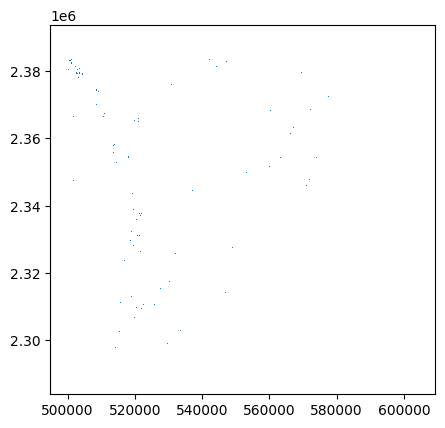

In [29]:
if sargassum_polygons is not None:
    sargassum_polygons.plot()
else:
    print("No polygons to display.")

## 14. Extracting Vertices and Centroids

We extract the vertices and centroids of the Sargassum polygons for further analysis.

### **Defining Functions to Obtain Vertices and Centroids**

#### **Extracting Vertices**

In [30]:
def get_polygon_vertices(df):
    """
    Extracts the vertices of polygons and converts them to MultiPoint geometries.

    Parameters:
    df (geopandas.GeoDataFrame): The GeoDataFrame containing the polygons.

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame with MultiPoint geometries representing the vertices.
    """
    points = df.explode(index_parts=False)
    points.geometry = points.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
    return points

#### **Calculating Centroids**

In [31]:
def get_polygon_centroids(df):
    """
    Calculates the centroids of the polygons.

    Parameters:
    df (geopandas.GeoDataFrame): The GeoDataFrame containing the polygons.

    Returns:
    geopandas.GeoDataFrame: A GeoDataFrame with Point geometries representing the centroids.
    """
    centroids = df.copy()
    centroids['geometry'] = centroids.geometry.centroid
    return centroids

### **Applying the Functions**

#### **Obtaining Vertices**

In [32]:
vertices = get_polygon_vertices(sargassum_polygons)
vertices

,ID,date,display_date,distance_to_coast_km,geometry
0,1,20230521T162457,05/21/23,36.4585,"MULTIPOINT (550940.000 2388820.000, 550940.000..."
1,2,20230521T162457,05/21/23,12.1786,"MULTIPOINT (513080.000 2388800.000, 513080.000..."
2,3,20230521T162457,05/21/23,36.4239,"MULTIPOINT (550940.000 2388780.000, 550940.000..."
3,4,20230521T162457,05/21/23,35.8281,"MULTIPOINT (550380.000 2388660.000, 550400.000..."
4,5,20230521T162457,05/21/23,35.3863,"MULTIPOINT (550020.000 2388380.000, 550040.000..."
...,...,...,...,...,...
6004,6005,20230521T162457,05/21/23,18.5531,"MULTIPOINT (523860.000 2289120.000, 523860.000..."
6005,6006,20230521T162457,05/21/23,18.5513,"MULTIPOINT (523840.000 2289100.000, 523840.000..."
6006,6007,20230521T162457,05/21/23,21.2999,"MULTIPOINT (527580.000 2289040.000, 527580.000..."
6007,6008,20230521T162457,05/21/23,21.3095,"MULTIPOINT (527560.000 2289000.000, 527580.000..."


#### **Obtaining Centroids**

In [33]:
centroids = get_polygon_centroids(sargassum_polygons)
centroids

,geometry,ID,date,display_date,distance_to_coast_km
0,POINT (550950.000 2388810.000),1,20230521T162457,05/21/23,36.4585
1,POINT (513100.000 2388790.000),2,20230521T162457,05/21/23,12.1786
2,POINT (550960.000 2388760.000),3,20230521T162457,05/21/23,36.4239
3,POINT (550398.235 2388559.412),4,20230521T162457,05/21/23,35.8281
4,POINT (550056.364 2388299.091),5,20230521T162457,05/21/23,35.3863
...,...,...,...,...,...
6004,POINT (523870.000 2289110.000),6005,20230521T162457,05/21/23,18.5531
6005,POINT (523850.000 2289090.000),6006,20230521T162457,05/21/23,18.5513
6006,POINT (527590.000 2289030.000),6007,20230521T162457,05/21/23,21.2999
6007,POINT (527563.333 2288976.667),6008,20230521T162457,05/21/23,21.3095


## 15. Saving Outputs

We save the polygons, vertices, and centroids to disk for future use or analysis.

### **Saving Polygons, Vertices, and Centroids**

In [34]:
# Save vertices to a GeoJSON file
vertices.to_file("sargassum_vertices_01.geojson", driver='GeoJSON')

# Save centroids to a GeoJSON file
centroids.to_file("sargassum_centroids_01.geojson", driver='GeoJSON')

### **Preparing the Output Image**
We prepare an output image highlighting the detected Sargassum areas.

In [35]:
# Create a copy of the original RGB bands
output_image = ds[["red", "green", "blue"]].copy()

### **Modifying the Image to Highlight Detections**

In [36]:
# Highlight Sargassum areas by modifying the RGB values
output_image["red"] = xr.where(filtered_sargassum_mask, output_image.red.max(), output_image.red)
output_image["green"] = xr.where(filtered_sargassum_mask, 0, output_image.green)
output_image["blue"] = xr.where(filtered_sargassum_mask, 0, output_image.blue)

- **Explanation**:
  - **Red Band**: Set to maximum value where Sargassum is detected.
  - **Green and Blue Bands**: Set to zero where Sargassum is detected.
  - This creates a visualization where Sargassum areas appear in bright red.

### **Visualizing the Output Image**

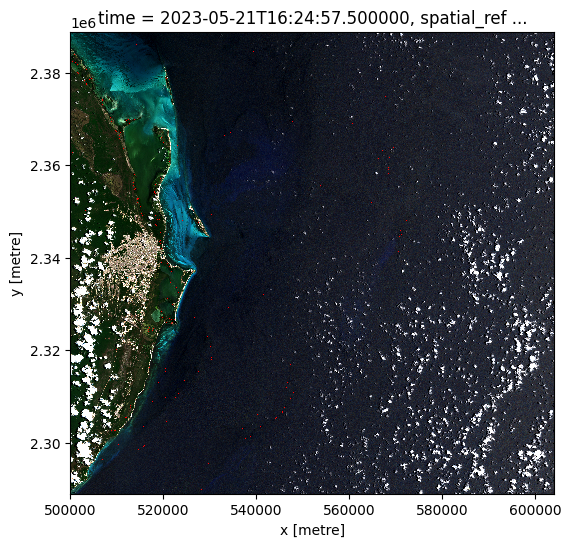

In [37]:
rgb(output_image, bands=["red", "green", "blue"])

### **Saving the Output Image as a GeoTIFF**

In [38]:
write_cog(
    geo_im=output_image.to_array(),
    fname='sargassum_detection_output_01.tif',
    overwrite=True
)

PosixPath('sargassum_detection_output_01.tif')

- **write_cog()**: Writes the image to a Cloud Optimized GeoTIFF file.

---

## 16. Conclusion

In this notebook, we've:

- Connected to a geospatial data cube to access satellite imagery.
- Loaded and visualized Sentinel-2 data for a specific area and time.
- Calculated the percentage of cloud cover and generated a cloud mask.
- Applied a Sargassum detection algorithm using spectral thresholds.
- Filtered detections using an entropy filter and cloud mask to reduce false positives.
- Converted the detections into vector polygons and calculated their distance to the coastline.
- Extracted vertices and centroids of the polygons for further analysis.
- Saved the results as GeoJSON files and visualized the detections on an RGB image.

This workflow provides a foundation for monitoring Sargassum blooms using satellite data, which is essential for environmental management and mitigation efforts.